# Bielik v3 - Function calling

Spróbujmy zbudować "agent bielik" - nazwa trochę na wyrost, ale zbudujemy takiego mini-agenta, który uzbrojony w narzędzia będzie potrafił rozpoznawać potrzebę wywołania zewnętrznych funkcji i wykorzystywać ich wyniki do udzielania kompletnych odpowiedzi.

**Na pierwszy ogień bez żadnych frameworków, spróbujmy zaimplementować to sami - aby dobrze zrozumieć jak potem to działa pod spodem, gdy będziesz w przyszłości korzystać z langchain, pydanticai, agent development kit, czy innych ;)**

* model: Bielik-4.5B-v3.0
* środowisko: darmowy Colab!
* tutorial: 5-20 minut

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Otwórz ten plik w colab
<a target="_blank" href="https://colab.research.google.com/github/ontaptom/wdi/blob/main/agent-bielik-4.5b_v3.0-colab.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg">

#  Colab Runtime ze wsparciem GPU

Aby bezproblemowo uruchomić Bielika v3, zmieńmy domyślny runtime type na **T4 GPU**, możesz to zrobić w menu Runtime-> Change Runtime type, lub po prawej stronie obok przycisku Connect:


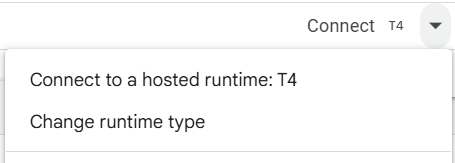

T4 GPU enabled runtime:

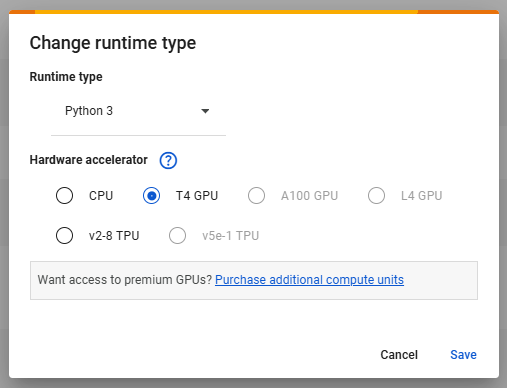

Całkowicie za darmo, jest limit godzinowy, który resetuje się następnego dnia :)

In [ ]:
# @title Instalacja bibliotek
!pip install -q transformers torch accelerate sentencepiece

In [ ]:
# @title Import bibliotek
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
# @title Sprawdzenie dostępności GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Używanie urządzenia: {device}")

if device == "cpu":
    print(f'Na pewno wybrany Runtime to T4 GPU? Wybierz go w Runtime -> Change Runtime type')

## Wymagane działania aby pobrać model

Na dzień dzisiejszy, aby pobrać model Bielik v3 ("speakleash/Bielik-4.5B-v3.0-Instruct") potrzebujemy:

- konto na huggingface (darmowe) - https://huggingface.co/
- wygenerować token (read-token będzie OK) do autoryzacji tutaj: https://huggingface.co/settings/tokens
- najłatwiej jest w colab dodać ten token w sekretach (po lewej stronie ikonka kluczyka), ale możemy go przekazać bezpośrednio w poniższym bloku (huggingface login)
- musimy udać się na stronę modelu https://huggingface.co/speakleash/Bielik-4.5B-v3.0-Instruct oraz zaakceptować 'Terms of use' (oczywiście po przeczytaniu :) ) - przycisk **Agree and access repository**

In [ ]:
# @title Huggingface login

from google.colab import userdata
from huggingface_hub import login


login(token=userdata.get('HF_TOKEN'))

print("Zalogowano do Hugging Face")

In [ ]:
# @title Pobranie modełu i tokenizera

model_name = "speakleash/Bielik-4.5B-v3.0-Instruct"

# Ładowanie tokenizera
print("Ładowanie tokenizera...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ładowanie modelu z precyzją bfloat16
print("Ładowanie modelu (to może potrwać kilka minut)...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="auto"
)

In [ ]:
# @title pierwszy prompt do bielika v3!

# Prosty test modelu
prompt = "Przepis na jajecznicę w dwóch zdaniach" # @param {type: "string"}
messages = [{"role": "user", "content": prompt}]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
outputs = model.generate(input_ids, max_new_tokens=1000)
response = tokenizer.batch_decode(outputs)[0]
print(response)

In [ ]:
# @title 1. Definicja prostej funkcji do sprawdzania pogody

def sprawdz_pogode(miasto):
    """Sprawdza pogodę w podanym mieście."""
    pogoda = {
        "warszawa": {"temperatura": "12°C", "opis": "słonecznie"},
        "kraków": {"temperatura": "10°C", "opis": "zachmurzenie"},
        "gdańsk": {"temperatura": "18°C", "opis": "deszczowo"},
        "bydgoszcz": {"temperatura": "23°C", "opis": "słonecznie"}
    }

    miasto = miasto.lower()
    if miasto in pogoda:
        return pogoda[miasto]
    else:
        return {"błąd": f"Nie znaleziono pogody dla miasta {miasto}"}

In [ ]:
# @title wywolajmy przykladowo ta funkcje

print(sprawdz_pogode("bydgoszcz"))

In [ ]:
# @title 2. Format funkcji dla modelu

import json

# Definicje funkcji dla modelu
funkcje_dla_modelu = [
    {
        "name": "sprawdz_pogode",
        "description": "Sprawdza aktualną pogodę w podanym polskim mieście",
        "parameters": {
            "type": "object",
            "properties": {
                "miasto": {
                    "type": "string",
                    "description": "Nazwa miasta w Polsce, np. Warszawa, Kraków"
                }
            },
            "required": ["miasto"]
        }
    }
    # Więcej funcji może tu trafić
]

# Konwertujemy na format JSON dla modelu
funkcje_json = json.dumps(funkcje_dla_modelu, ensure_ascii=False)
print("Definicje funkcji dla modelu:")
print(funkcje_json)

In [ ]:
# @title 3. Zapytanie do modelu z definicją funkcji

# Prosty prompt z pytaniem o pogodę
prompt = "Jaka jest pogoda w Bydgoszczy?"

# Prosty prompt systemowy
system = "Jesteś pomocnym asystentem AI. Gdy potrzebujesz dodatkowych informacji, możesz używać dostępnych funkcji."

# Dodajemy definicję funkcji do prompta użytkownika
pelny_prompt = f"{prompt}\n\nDostępne funkcje: {funkcje_json}"

# Formatujemy prompt ręcznie (bez apply_chat_template)
formatted_prompt = f"<s><|im_start|> system\n{system}<|im_end|>\n<|im_start|> user\n{pelny_prompt}<|im_end|>\n<|im_start|> assistant\n"

# Tokenizacja
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)

# Generowanie odpowiedzi
outputs = model.generate(inputs["input_ids"], max_new_tokens=500)

# Dekodowanie odpowiedzi
raw_response = tokenizer.decode(outputs[0], skip_special_tokens=False)
print("Surowa odpowiedź modelu:")
print(raw_response)

In [ ]:
# @title 4. Proste wyodrębnienie wywołania funkcji

import re

def wyodrebnij_wywolanie_funkcji(tekst):
    """Wyodrębnia wywołanie funkcji z tagu <tool_call>."""
    # Szukamy wzorca <tool_call> JSON </tool_call>
    pattern = r'<tool_call>\s*(.*?)\s*</tool_call>'
    match = re.search(pattern, tekst, re.DOTALL)

    if match:
        try:
            wywolanie = json.loads(match.group(1))
            # Konwertujemy "name" na "function" dla spójności
            if "name" in wywolanie:
                wywolanie["function"] = wywolanie["name"]
            return wywolanie
        except:
            pass

    return None

# Wyodrębniamy wywołanie funkcji
wywolanie_funkcji = wyodrebnij_wywolanie_funkcji(raw_response)
print("\nWyodrębnione wywołanie funkcji:")
print(json.dumps(wywolanie_funkcji, indent=2, ensure_ascii=False) if wywolanie_funkcji else "Nie znaleziono wywołania funkcji")

In [ ]:
# @title 5. Proste i bezpośrednie wykonanie funkcji

# Wykonujemy funkcję, jeśli znaleziono wywołanie
if wywolanie_funkcji and "function" in wywolanie_funkcji and "arguments" in wywolanie_funkcji:
    nazwa_funkcji = wywolanie_funkcji["function"]
    argumenty = wywolanie_funkcji["arguments"]

    print(f"\nWykonuję funkcję: {nazwa_funkcji}")
    print(f"Z argumentami: {json.dumps(argumenty, ensure_ascii=False)}")

    # Po prostu próbujemy wykonać funkcję
    try:
        # Używamy eval() aby wywołać funkcję z argumentami
        wynik_funkcji = eval(f"{nazwa_funkcji}(**{argumenty})")
    except Exception as e:
        wynik_funkcji = {"błąd": str(e)}
        print(f"\nBłąd: {str(e)}")
else:
    wynik_funkcji = None
    print("\nNie można wykonać funkcji - brak poprawnego wywołania.")

# Wyświetlamy wynik, jeśli jest
if wynik_funkcji is not None:
    print("\nWynik funkcji:")
    print(json.dumps(wynik_funkcji, indent=2, ensure_ascii=False))

In [ ]:
# @title 6. Wysłanie wyniku funkcji do modelu i uzyskanie końcowej odpowiedzi

# Jeśli mamy wynik (z kroku 5), wysyłamy go do modelu
if wynik_funkcji is not None:
    # Tworzymy nowy prompt zawierający całą historię
    prompt_z_wynikiem = (
        f"<s><|im_start|> system\n{system}<|im_end|>\n"
        f"<|im_start|> user\n{prompt}<|im_end|>\n"
        f"<|im_start|> assistant\n"
        f"Aby sprawdzić aktualną pogodę w Bydgoszczy, użyję funkcji `sprawdz_pogode` z miastem \"Bydgoszcz\".\n\n"
        f"<tool_call> {json.dumps(wywolanie_funkcji, ensure_ascii=False)}</tool_call><|im_end|>\n"
        f"<|im_start|> tool\n"
        f"{json.dumps(wynik_funkcji, ensure_ascii=False)}<|im_end|>\n"
        f"<|im_start|> assistant\n"
    )

    # Tokenizacja
    final_inputs = tokenizer(prompt_z_wynikiem, return_tensors="pt").to(device)

    # Generowanie odpowiedzi
    final_outputs = model.generate(final_inputs["input_ids"], max_new_tokens=500)

    # Dekodowanie odpowiedzi
    final_response = tokenizer.decode(final_outputs[0], skip_special_tokens=False)
    print("\nOstateczna odpowiedź modelu (z wynikiem funkcji):")
    print(final_response)

    print("\n\n-------------------------------\n\n")
    # Wyodrębniamy tylko ostatnią odpowiedź asystenta
    import re
    pattern = r'<\|im_start\|\>\s+assistant\n(.*?)<\|im_end\|>'
    matches = re.findall(pattern, final_response, re.DOTALL)

    if matches:
        last_assistant = matches[-1].strip()  # Bierzemy ostatnie dopasowanie
        print("\nOstateczna odpowiedź (oczyszczona):")
        print(last_assistant)
    else:
        print("\nNie znaleziono odpowiedzi asystenta")

In [ ]:
def agent_bielik(prompt, system=None, narzedzia_json=funkcje_json, debug=False):
    """
    Funkcja realizująca pełny przepływ function calling z modelem Bielik.

    Args:
        prompt: Zapytanie użytkownika
        system: Opcjonalny prompt systemowy (domyślny zostanie użyty, jeśli nie podano)
        debug: Czy wyświetlać informacje debugowania

    Returns:
        Ostateczna odpowiedź modelu
    """
    import json
    import re

    # 1. Przygotowanie promptu systemowego
    if system is None:
        system = "Jesteś pomocnym asystentem AI. Gdy potrzebujesz dodatkowych informacji, możesz używać dostępnych funkcji."

    # 2. Dodanie definicji funkcji do promptu
    pelny_prompt = f"{prompt}\n\nDostępne funkcje: {narzedzia_json}"

    # 3. Wysłanie zapytania do modelu
    formatted_prompt = f"<s><|im_start|> system\n{system}<|im_end|>\n<|im_start|> user\n{pelny_prompt}<|im_end|>\n<|im_start|> assistant\n"
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
    outputs = model.generate(inputs["input_ids"], max_new_tokens=500)
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)

    if debug:
        print("Pirwsze zapytanie do modelu:\n------------------")
        print(formatted_prompt)
        print("Surowa odpowiedź modelu na pirwsze zapytanie:\n------------------")
        print(response)

    # 4. Wyodrębnienie wywołania funkcji
    def wyodrebnij_wywolanie_funkcji(tekst):
        """Wyodrębnia wywołanie funkcji z tagu <tool_call>."""
        pattern = r'<tool_call>\s*(.*?)\s*</tool_call>'
        match = re.search(pattern, tekst, re.DOTALL)

        if match:
            try:
                wywolanie = json.loads(match.group(1))
                if "name" in wywolanie:
                    wywolanie["function"] = wywolanie["name"]
                return wywolanie
            except:
                pass

        return None

    wywolanie_funkcji = wyodrebnij_wywolanie_funkcji(response)

    if debug and wywolanie_funkcji:
        print("\nWyodrębnione wywołanie funkcji:\n------------------")
        print(json.dumps(wywolanie_funkcji, indent=2, ensure_ascii=False))

    # 5. Wykonanie funkcji, jeśli znaleziono wywołanie
    wynik_funkcji = None

    if wywolanie_funkcji and "function" in wywolanie_funkcji and "arguments" in wywolanie_funkcji:
        nazwa_funkcji = wywolanie_funkcji["function"]
        argumenty = wywolanie_funkcji["arguments"]

        if debug:
            print(f"\nWykonuję funkcję: {nazwa_funkcji}\n------------------")
            print(f"Z argumentami: {json.dumps(argumenty, ensure_ascii=False)}")

        # Próbujemy wykonać funkcję
        try:
            # Używamy eval() aby wywołać funkcję z argumentami
            wynik_funkcji = eval(f"{nazwa_funkcji}(**{argumenty})")
        except Exception as e:
            wynik_funkcji = {"błąd": str(e)}
            if debug:
                print(f"\nBłąd: {str(e)}")

    # 6. Jeśli nie znaleziono wywołania funkcji, zwracamy bezpośrednią odpowiedź
    if wynik_funkcji is None:
        try:
            # Wyodrębniamy czystą odpowiedź asystenta
            pattern = r'<\|im_start\|\>\s+assistant\n(.*?)<\|im_end\|>'
            matches = re.findall(pattern, response, re.DOTALL)

            if matches:
                clean_response = matches[-1].strip()
                return clean_response
            else:
                return "Nie udało się wyodrębnić odpowiedzi asystenta."
        except Exception as e:
            return f"Błąd podczas przetwarzania odpowiedzi: {str(e)}"

    # 7. Wysłanie wyniku funkcji do modelu
    if debug and wynik_funkcji is not None:
        print("\nWynik funkcji:\n------------------")
        print(json.dumps(wynik_funkcji, indent=2, ensure_ascii=False))

    # Przygotowanie kontekstu z wynikiem funkcji
    # Wyodrębnijmy najpierw odpowiedź asystenta z oryginalnej odpowiedzi
    pattern = r'<\|im_start\|\>\s+assistant\n(.*?)<\|im_end\|>'
    matches = re.findall(pattern, response, re.DOTALL)
    if matches:
        assistant_response = matches[-1].strip()
    else:
        assistant_response = "Nie mogę znaleźć odpowiedzi asystenta."

    # Teraz budujemy pełny prompt z wynikiem funkcji
    prompt_z_wynikiem = (
        f"<s><|im_start|> system\n{system}<|im_end|>\n"
        f"<|im_start|> user\n{prompt}<|im_end|>\n"
        f"<|im_start|> assistant\n"
        f"{assistant_response}<|im_end|>\n"
        f"<|im_start|> tool\n"
        f"{json.dumps(wynik_funkcji, ensure_ascii=False)}<|im_end|>\n"
        f"<|im_start|> assistant\n"
    )
    if debug:
        print("\nDrugie zapytanie do modelu:\n------------------")
        print(prompt_z_wynikiem)
    # Generowanie ostatecznej odpowiedzi
    final_inputs = tokenizer(prompt_z_wynikiem, return_tensors="pt").to(device)
    final_outputs = model.generate(final_inputs["input_ids"], max_new_tokens=500)
    final_response = tokenizer.decode(final_outputs[0], skip_special_tokens=False)

    if debug:
        print("\nOstateczna odpowiedź modelu:\n------------------")
        print(final_response)

    # Wyodrębnianie ostatniej odpowiedzi asystenta
    pattern = r'<\|im_start\|\>\s+assistant\n(.*?)<\|im_end\|>'
    matches = re.findall(pattern, final_response, re.DOTALL)

    if matches:
        return matches[-1].strip()  # Ostatnia odpowiedź asystenta
    else:
        return "Nie udało się wyodrębnić ostatecznej odpowiedzi."

In [ ]:
odpowiedz = agent_bielik("Jaka jest pogoda w Warszawie?", debug=False)
print("\nOstateczna odpowiedź:")
print(odpowiedz)